## 1. Package Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer


## 2. Data Import

In [2]:
df = pd.read_csv('spotify_reviews.csv')
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,437314fe-1b1d-4352-abea-12fec30fce58,Rajib Das,It's good,4,0,NaN,2024-05-09 16:28:13,NaN
1,4933ad2c-c70a-4a84-957d-d405439b2e0f,Mihaela Claudia Neagu,"I love this app so much, I've been using Spoti...",5,0,8.9.38.494,2024-05-09 16:27:18,8.9.38.494
2,1ab275fb-59bf-42c7-88ef-b85901f0445e,JONATHAN GRACIA,Perfect,5,0,8.9.36.616,2024-05-09 16:27:03,8.9.36.616
3,b38406eb-7b11-4ceb-a45c-d7f28fb5d382,Cam Rempel,Best all around music streaming app I have use...,5,0,8.9.38.494,2024-05-09 16:26:19,8.9.38.494
4,7be7999d-4cb6-47b9-8414-d7bdaa9df578,Your clowness (Her Clowness),Are y'all fr gatekeeping the play button on so...,1,0,8.9.38.494,2024-05-09 16:26:14,8.9.38.494


## 3. Data Pre-processing

In [3]:
print(f'Original Spotify review data sets contains {len(df)} rows')
print(f'There are {len(df.columns)} columns: ')
for col in df.columns:
    print(f'• {col}')


Original Spotify review data sets contains 84165 rows
There are 8 columns: 
• reviewId
• userName
• content
• score
• thumbsUpCount
• reviewCreatedVersion
• at
• appVersion


In [4]:
print(f'Missing values in each column: ')
print(f'{df.isnull().sum()}')

Missing values in each column: 
reviewId                   0
userName                   4
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    5768
at                         0
appVersion              5768
dtype: int64


##### 3.1 Data Cleaning Strategy
* The goal of this project is to analyze the sentiment of user's feedback of different version. Therefore, the data cleaning strategy is to drop all the rows that contains NA values, inserting a mean value or some value x (such as 'Unknow Version' or 0.0.0) will not suit the goal of this project.

In [5]:
df_clean = df.dropna()
print("Each column's missing value after cleaned: ")
print(f'{df_clean.isnull().sum()}')

Each column's missing value after cleaned: 
reviewId                0
userName                0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
appVersion              0
dtype: int64


In [6]:
df_clean.loc[:,'at']

1        2024-05-09 16:27:18
2        2024-05-09 16:27:03
3        2024-05-09 16:26:19
4        2024-05-09 16:26:14
5        2024-05-09 16:24:51
                ...         
84159    2019-04-26 02:58:15
84160    2020-04-30 10:02:07
84161    2019-10-11 16:28:13
84163    2020-03-28 03:50:24
84164    2020-06-13 03:27:52
Name: at, Length: 78393, dtype: object

In [7]:
df_clean['at'] = pd.to_datetime(df_clean['at'])
df_clean['year'] = df_clean['at'].dt.year

/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_10863/1706107376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['at'] = pd.to_datetime(df_clean['at'])
/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_10863/1706107376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['year'] = df_clean['at'].dt.year


##### 3.2 Initial Data Visualization

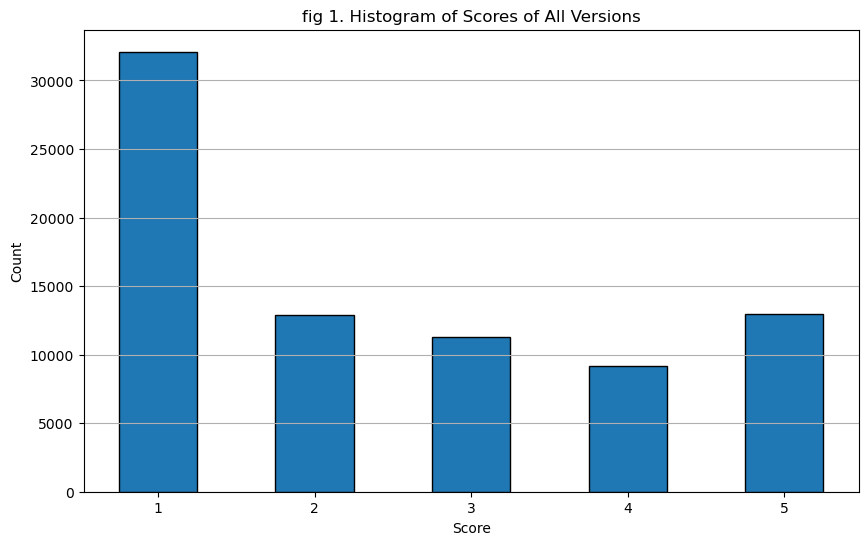

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['score'], 
         bins=[0.5 + i for i in range(6)], 
         edgecolor='black',
        rwidth = 0.5)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('fig 1. Histogram of Scores of All Versions')
plt.xticks(range(1, 6))
plt.grid(axis='y')
plt.show()


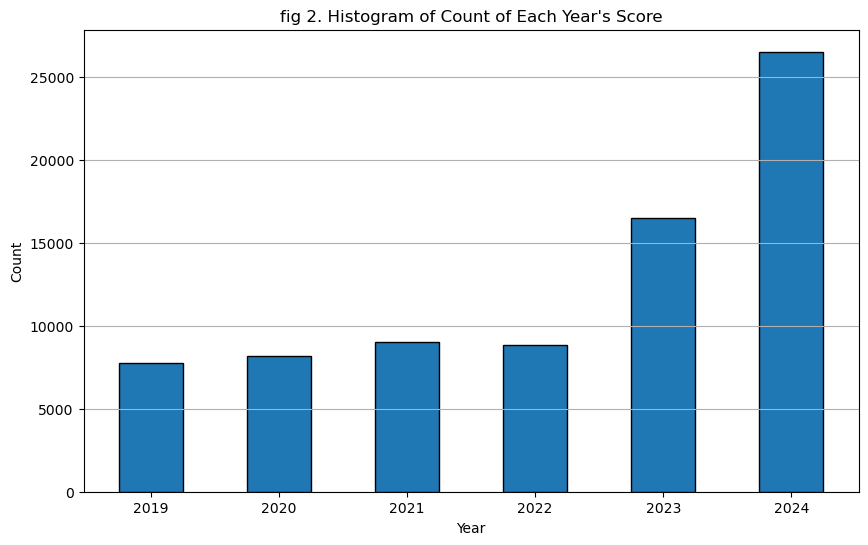

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['year'], 
         bins=[0.5 + i for i in range(2018, 2025)], 
         edgecolor='black',
        rwidth = 0.5)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title("fig 2. Histogram of Count of Each Year's Score")
plt.grid(axis='y')
plt.show()

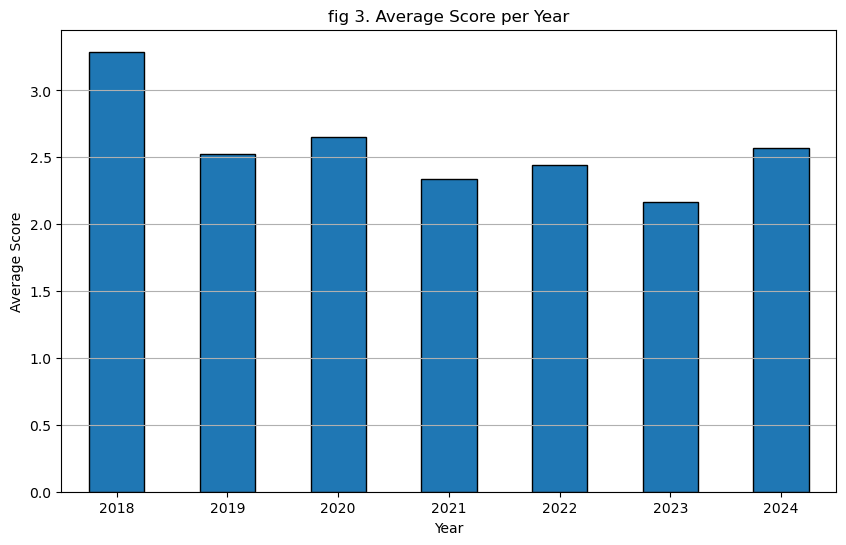

In [10]:
average_scores_per_year = df_clean.groupby('year')['score'].mean()

plt.figure(figsize=(10, 6))
average_scores_per_year.plot(kind='bar', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.title('fig 3. Average Score per Year')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

##### 3.3 Summary

The number of 1 score reviews is the highest for spotify, more reviews are in year 2024, and the general trend of the average score in each year from 2018 to 2024 is decreasing, year 2023 has the lowest average score.

## 4. Text cleaning
* Symbols removing
* Drop non-english characters
* text tokenize
* text lemmatize

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/penglishao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/penglishao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/penglishao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
def text_cleaner(t):
    #Remove all text that is either a word, number, question mark, 
    #exclamation mark, or a space, make sure it is english
    t = re.sub(r'[^a-zA-Z0-9\s!?]', '', t)
    
    #Lower
    t = t.lower()
    
    #Word tokenize and remove stop words
    wt = word_tokenize(t)
    
    sw = set(stopwords.words('english'))
    filtered_text = [w for w in wt if w not in sw]
    
    #Transform words to basic norm form
    lemma_text = [lemmatizer.lemmatize(w) for w in filtered_text]
    #Transform word to basic verb form
    lemma_text = [lemmatizer.lemmatize(w, pos = 'v') for w in lemma_text]
    
    return ' '.join(lemma_text)

In [13]:
df_clean['clean_content'] = df_clean['content'].apply(text_cleaner)
print(df_clean[['content', 'clean_content']].head())


                                             content  \
1  I love this app so much, I've been using Spoti...   
2                                            Perfect   
3  Best all around music streaming app I have use...   
4  Are y'all fr gatekeeping the play button on so...   
5                                           Loved it   

                                       clean_content  
1  love app much ive use spotify 2 year different...  
2                                            perfect  
3  best around music stream app use family plan g...  
4           yall fr gatekeeping play button song ! ?  
5                                               love  


/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_10863/2220158706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['clean_content'] = df_clean['content'].apply(text_cleaner)


## 5. Setiment Analysis

##### 6.1 Sentiment Identification
Identify the sentiment of comments: 
* Positive
* Negative
* Neutral


Three packages that I use:
* Vader
* Textblob
* Bert

### 5.1 Vader

In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer(t):
    scores = analyzer.polarity_scores(t)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'
    
df_clean['sentiment'] = df_clean['clean_content'].apply(sentiment_analyzer)


/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_10863/1717764352.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sentiment'] = df_clean['clean_content'].apply(sentiment_analyzer)


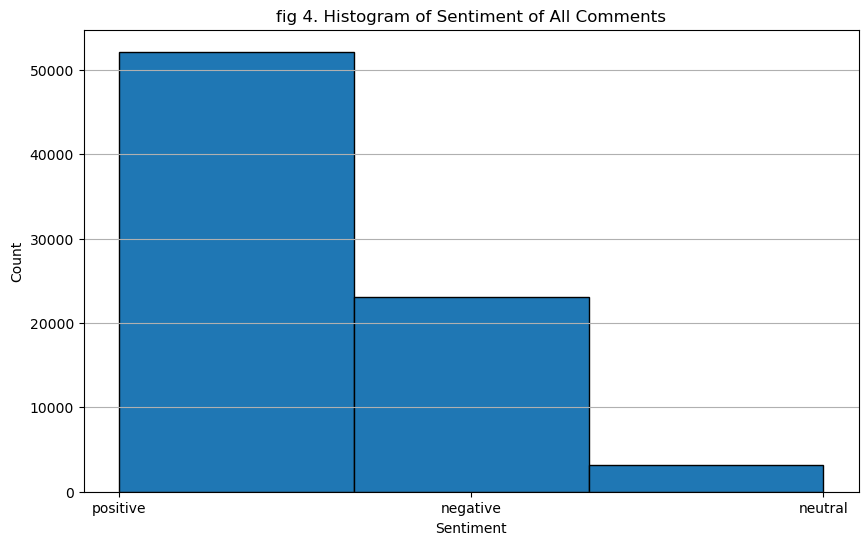

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['sentiment'],
         bins = 3,
         edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('fig 4. Histogram of Sentiment of All Comments')
plt.grid(axis='y')
plt.show()

### 5.2 Textblob

/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_10863/671373536.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['textblob_sentiment'] = df_clean['clean_content'].apply(textblob_sentiment_analyzer)


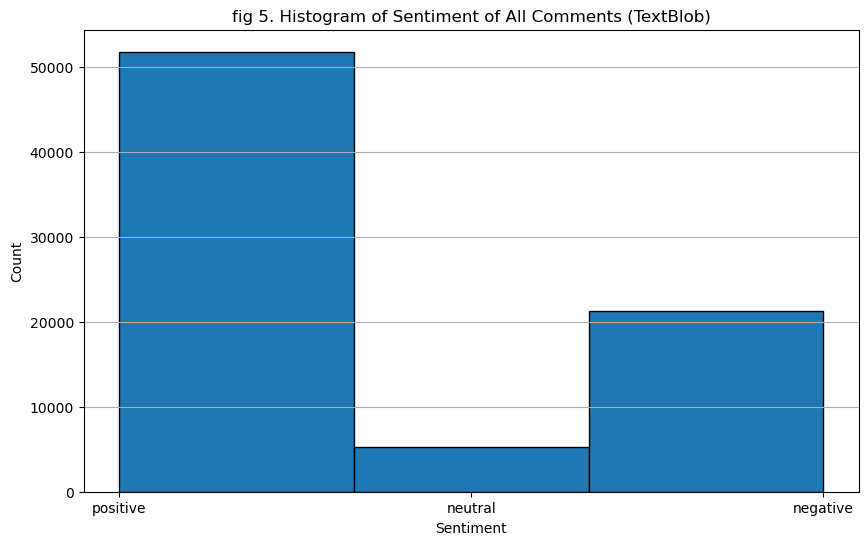

In [16]:
from textblob import TextBlob

def textblob_sentiment_analyzer(t):
    analysis = TextBlob(t)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df_clean['textblob_sentiment'] = df_clean['clean_content'].apply(textblob_sentiment_analyzer)



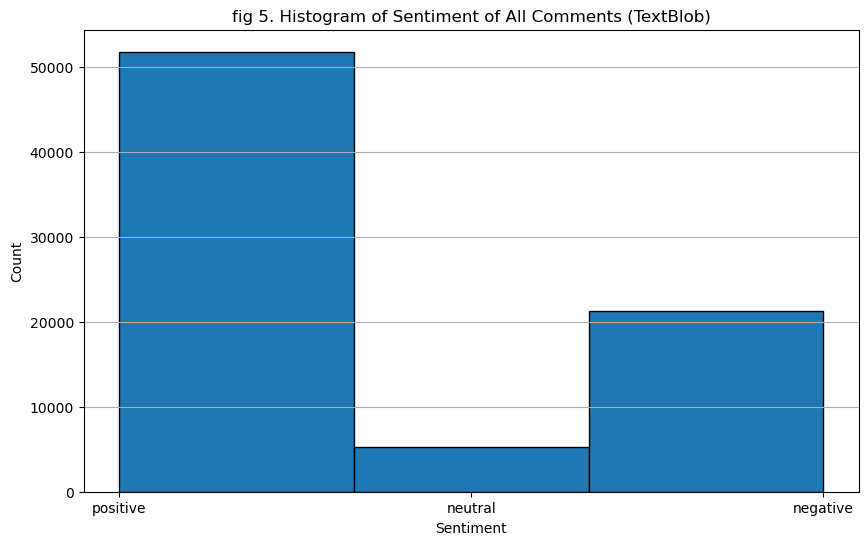

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['textblob_sentiment'],
         bins=3,
         edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('fig 5. Histogram of Sentiment of All Comments (TextBlob)')
plt.grid(axis='y')
plt.show()

### 5.3 Bert

/Users/penglishao/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_10863/1362250379.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['bert_sentiment'] = df_clean['clean_content'].apply(bert_sentiment_an

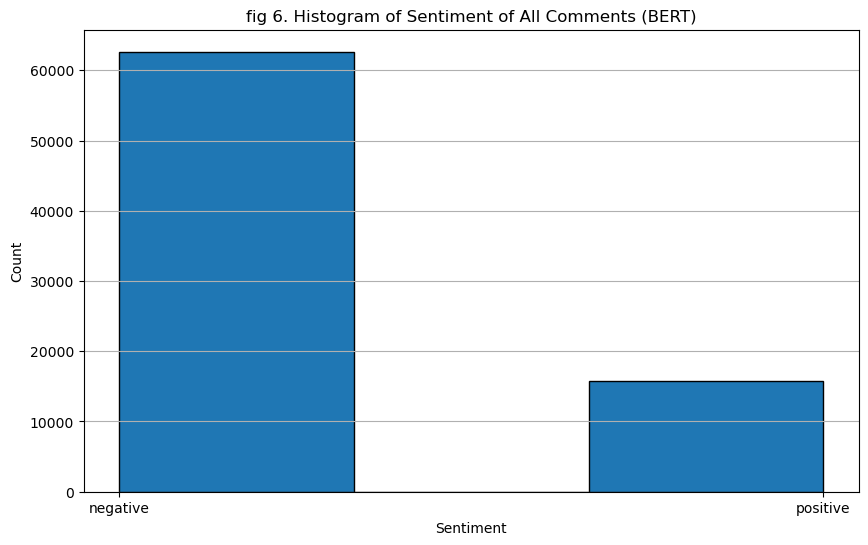

In [18]:
from transformers import pipeline

sentiment_pipeline = pipeline('sentiment-analysis')

def bert_sentiment_analyzer(t):
    result = sentiment_pipeline(t)[0]
    if result['label'] == 'POSITIVE':
        return 'positive'
    elif result['label'] == 'NEGATIVE':
        return 'negative'
    else:
        return 'neutral'

df_clean['bert_sentiment'] = df_clean['clean_content'].apply(bert_sentiment_analyzer)



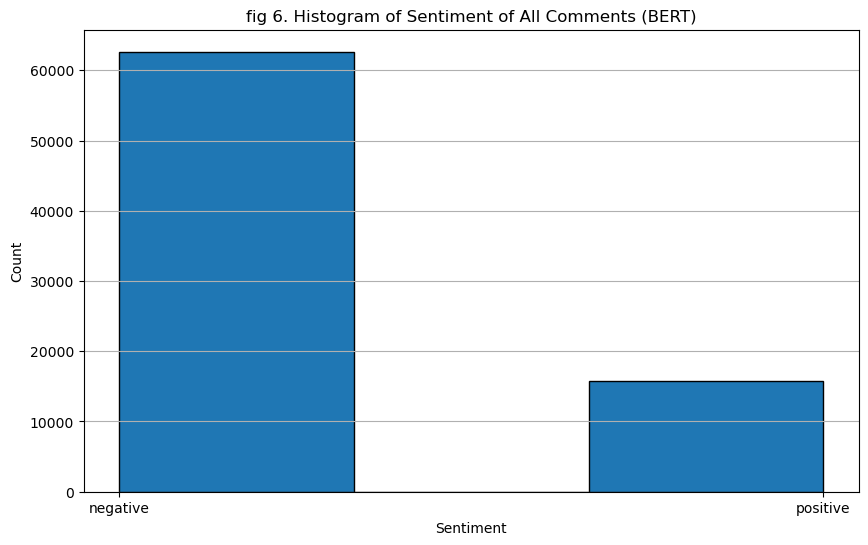

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['bert_sentiment'],
         bins=3,
         edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('fig 6. Histogram of Sentiment of All Comments (BERT)')
plt.grid(axis='y')
plt.show()

In [32]:
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
df_clean['sentiment_numeric'] = df_clean['bert_sentiment'].map(sentiment_mapping)
correlation = df_clean[['score', 'sentiment_numeric']].corr()
print(correlation)

                      score  sentiment_numeric
score              1.000000           0.517931
sentiment_numeric  0.517931           1.000000


/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_10863/650336158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sentiment_numeric'] = df_clean['bert_sentiment'].map(sentiment_mapping)


## 6. Keywords Extraction

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_features=200)
tfidf_matrix = vectorizer.fit_transform(df_clean['clean_content'])

keywords = vectorizer.get_feature_names_out()
print(keywords)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=keywords)
print(tfidf_df)

positive_reviews = df_clean[df_clean['bert_sentiment'] == 'positive']
negative_reviews = df_clean[df_clean['bert_sentiment'] == 'negative']

positive_tfidf_matrix = vectorizer.transform(positive_reviews['clean_content'])
negative_tfidf_matrix = vectorizer.transform(negative_reviews['clean_content'])

positive_keywords = pd.DataFrame(positive_tfidf_matrix.toarray(), columns=keywords)
negative_keywords = pd.DataFrame(negative_tfidf_matrix.toarray(), columns=keywords)

positive_keyword_scores = positive_keywords.mean().sort_values(ascending=False)
negative_keyword_scores = negative_keywords.mean().sort_values(ascending=False)

print("Top positive keywords:")
print(positive_keyword_scores.head(20))

print("Top negative keywords:")
print(negative_keyword_scores.head(20))

keyword_sentiment = {}
for keyword in keywords:
    pos_score = positive_keyword_scores.get(keyword, 0)
    neg_score = negative_keyword_scores.get(keyword, 0)
    if pos_score > neg_score:
        keyword_sentiment[keyword] = 'positive'
    elif neg_score > pos_score:
        keyword_sentiment[keyword] = 'negative'
    else:
        keyword_sentiment[keyword] = 'neutral'

def rule_based_sentiment_analysis(text):
    tokens = text.split()
    sentiment_score = 0
    for token in tokens:
        if keyword_sentiment.get(token) == 'positive':
            sentiment_score += 1
        elif keyword_sentiment.get(token) == 'negative':
            sentiment_score -= 1
    if sentiment_score > 0:
        return 'positive'
    elif sentiment_score < 0:
        return 'negative'
    else:
        return 'neutral'

df_clean['rule_based_sentiment'] = df_clean['clean_content'].apply(rule_based_sentiment_analysis)

comparison = df_clean[['bert_sentiment', 'rule_based_sentiment']]
print(comparison.head(20))

consistency = (df_clean['bert_sentiment'] == df_clean['rule_based_sentiment']).mean()
print(f"Consistency between rule-based and BERT sentiment analysis: {consistency:.2f}")


['10' '30' 'able' 'account' 'actually' 'ad' 'add' 'album' 'allow' 'almost'
 'already' 'also' 'always' 'amaze' 'android' 'annoy' 'another' 'anymore'
 'anything' 'app' 'apps' 'artist' 'back' 'bad' 'become' 'best' 'better'
 'bug' 'button' 'buy' 'cancel' 'cant' 'car' 'change' 'choose' 'click'
 'close' 'come' 'completely' 'connect' 'connection' 'constantly' 'could'
 'crash' 'data' 'day' 'delete' 'device' 'didnt' 'different' 'disappoint'
 'doesnt' 'dont' 'download' 'easy' 'enjoy' 'even' 'ever' 'every'
 'everything' 'experience' 'favorite' 'feature' 'find' 'fine' 'first'
 'fix' 'force' 'free' 'frustrate' 'get' 'give' 'go' 'good' 'great'
 'happen' 'hate' 'hear' 'help' 'hour' 'however' 'ill' 'im' 'instead'
 'internet' 'isnt' 'issue' 'ive' 'keep' 'know' 'last' 'let' 'library'
 'like' 'limit' 'list' 'listen' 'load' 'log' 'long' 'look' 'lot' 'love'
 'lyric' 'make' 'many' 'minute' 'mobile' 'mode' 'money' 'month' 'much'
 'music' 'need' 'never' 'new' 'next' 'nothing' 'offline' 'one' 'open'
 'option' 

/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_10863/377278350.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['rule_based_sentiment'] = df_clean['clean_content'].apply(rule_based_sentiment_analysis)


## 7. World Cloud

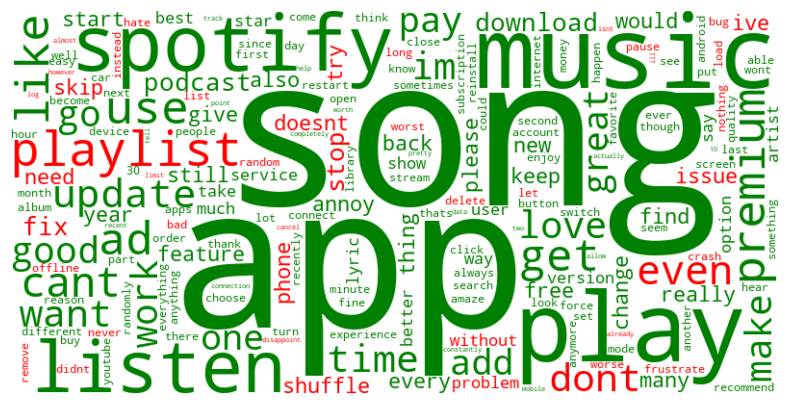

In [22]:
from wordcloud import WordCloud


word_freq = {word: tfidf_matrix[:, i].sum() for i, word in enumerate(keywords)}

word_sentiments = {word: bert_sentiment_analyzer(word) for word in keywords}

def color_func(word, *args, **kwargs):
    sentiment = word_sentiments.get(word, 'neutral')
    if sentiment == 'positive':
        return 'green'
    elif sentiment == 'negative':
        return 'red'
    else:
        return 'grey'

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 8. Visualization

### 8.1 Sentiment Trend Over Time

/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_10863/2250694232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['year'] = pd.to_datetime(df_clean['at']).dt.year


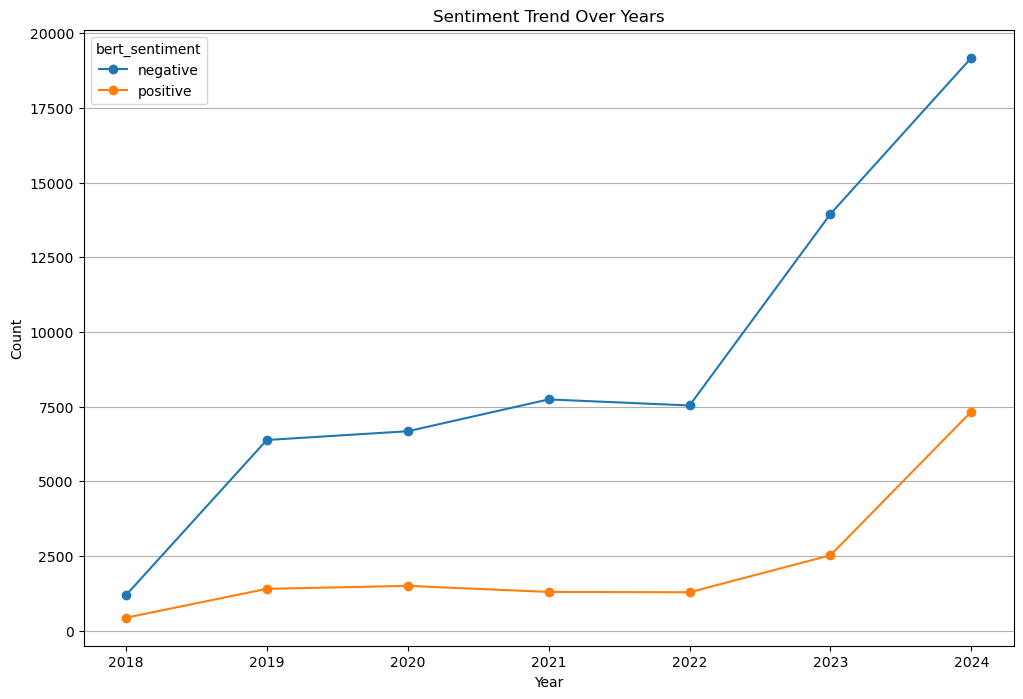

In [23]:
df_clean['year'] = pd.to_datetime(df_clean['at']).dt.year
sentiment_by_year = df_clean.groupby(['year', 'bert_sentiment']).size().unstack()

sentiment_by_year.plot(kind='line', figsize=(12, 8), marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Sentiment Trend Over Years')
plt.grid(axis='y')
plt.show()


### 8.2 Score Distribution by Sentiment

<Figure size 1000x600 with 0 Axes>

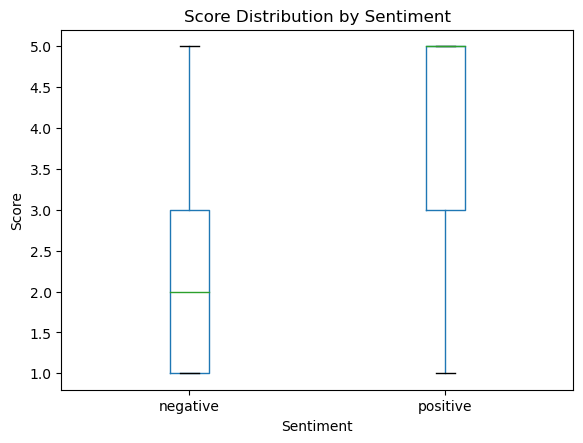

In [24]:
plt.figure(figsize=(10, 6))
df_clean.boxplot(column='score', by='bert_sentiment', grid=False)
plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.title('Score Distribution by Sentiment')
plt.suptitle('')
plt.show()


### 8.3 Negative Keywords Distribution

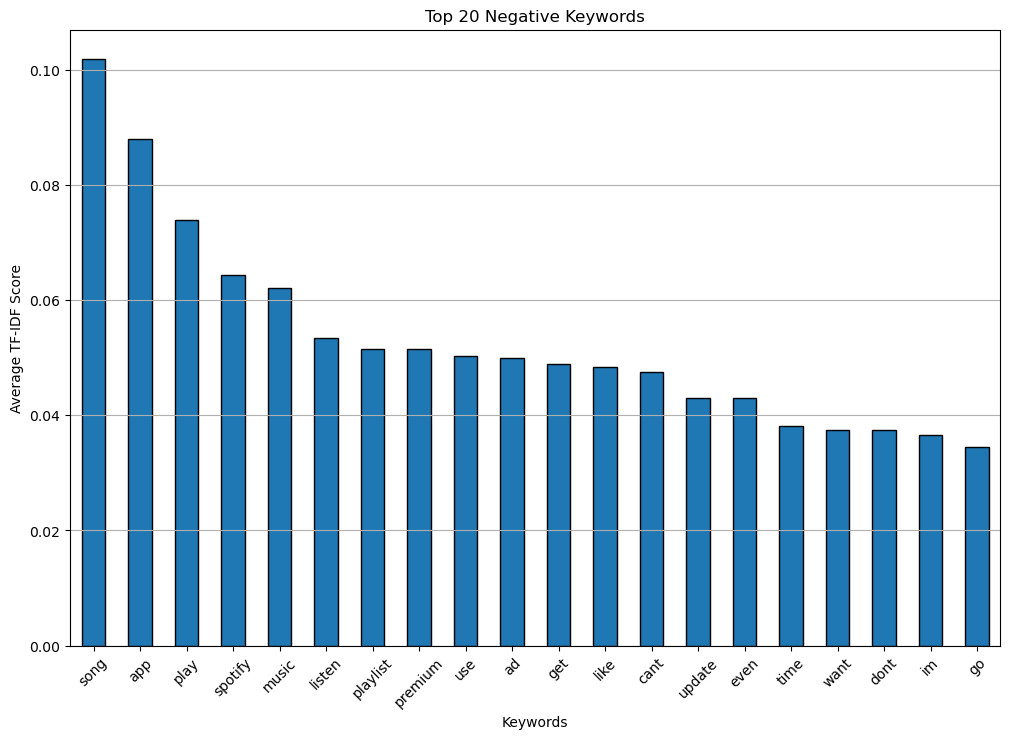

In [25]:
plt.figure(figsize=(12, 8))
negative_keyword_scores.head(20).plot(kind='bar', edgecolor='black')
plt.xlabel('Keywords')
plt.ylabel('Average TF-IDF Score')
plt.title('Top 20 Negative Keywords')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## 9. Topic Analysis

In [26]:
vectorizer = TfidfVectorizer(max_features=200)
negative_tfidf_matrix = vectorizer.fit_transform(negative_reviews['clean_content'])
negative_keywords = vectorizer.get_feature_names_out()
negative_tfidf_df = pd.DataFrame(negative_tfidf_matrix.toarray(), columns=negative_keywords)

In [27]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(negative_tfidf_matrix)

for index, topic in enumerate(lda.components_):
    print(f"Top 10 words for topic #{index}:")
    print([negative_keywords[i] for i in topic.argsort()[-10:]])
    print("\n")

Top 10 words for topic #0:
['im', 'pay', 'premium', 'ive', 'service', 'year', 'use', 'music', 'app', 'spotify']


Top 10 words for topic #1:
['time', 'spotify', 'music', 'song', 'fix', 'stop', 'phone', 'work', 'play', 'app']


Top 10 words for topic #2:
['music', 'listen', 'even', 'spotify', 'lyric', 'worst', 'app', 'cant', 'premium', 'song']


Top 10 words for topic #3:
['premium', 'podcast', 'music', 'minute', '30', 'free', 'song', 'listen', 'get', 'ad']


Top 10 words for topic #4:
['music', 'app', 'want', 'listen', 'add', 'shuffle', 'like', 'play', 'playlist', 'song']




In [28]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=1)
lda.fit(negative_tfidf_matrix)

for index, topic in enumerate(lda.components_):
    print(f"Top 10 words for topic #{index}:")
    print([negative_keywords[i] for i in topic.argsort()[-10:]])
    print("\n")

Top 10 words for topic #0:
['year', 'connect', 'work', 'device', 'service', 'download', 'use', 'music', 'app', 'spotify']


Top 10 words for topic #1:
['music', 'artist', 'want', 'listen', 'add', 'shuffle', 'like', 'play', 'playlist', 'song']


Top 10 words for topic #2:
['pay', 'music', 'song', 'premium', 'listen', '30', 'minute', 'free', 'get', 'ad']


Top 10 words for topic #3:
['issue', 'music', 'time', 'song', 'fix', 'phone', 'work', 'stop', 'play', 'app']


Top 10 words for topic #4:
['skip', 'lyric', 'even', 'worst', 'spotify', 'listen', 'app', 'cant', 'premium', 'song']




In [29]:
print("Sample negative reviews:")
print(negative_reviews['content'].head(20))

Sample negative reviews:
1     I love this app so much, I've been using Spoti...
4     Are y'all fr gatekeeping the play button on so...
11    I'd normally give a 5 or 4 star rating, but th...
14    Do whatever you want bring up new update I'll ...
15    Spotify trying to make itself the worst music ...
19                                Ther are no free skip
22    Says it's offline when it's completely online ...
23            All time companion through thick and thin
28    For the last two weeks, audio playback ends ra...
29    App Crashes in samsung fold .. no support even...
32       Why I am seeing Congress add .. I am bjp bhakt
33    it so frustrating that you removed free lyrics...
35    Spotify removed the ability to automatically r...
38    Worse update ever.. can't even listen to music...
39                    Can't skip ads of long duration..
43    Offers audiobooks but limits your listening ti...
46    More ads than music. Ads after every song. it'...
47    I am not able to 

In [31]:
for index, topic in enumerate(lda.components_):
    print(f"Top 10 words for topic #{index}:")
    print([negative_keywords[i] for i in topic.argsort()[-10:]])
    print("\nSample reviews for this topic:\n")
    topic_indices = lda.transform(negative_tfidf_matrix)[:, index].argsort()[-5:]
    for i in topic_indices:
        print(negative_reviews.iloc[i]['content'])
        print("\n")

Top 10 words for topic #0:
['year', 'connect', 'work', 'device', 'service', 'download', 'use', 'music', 'app', 'spotify']

Sample reviews for this topic:

Used to love this app, but I'm extremely frustrated with it now. I pay for premium, and no matter how good my Internet connection is, I get told I need to "go online to see the menu." I can't even access the songs I've downloaded - isn't the whole point of downloading them to be able to access them offline? This has been an issue for months now, but recently it happens pretty much any time I try to use the app. Think it's time to start looking for other services.


This app, to me, used to be 5/5 and has and still is my only go to music platform. However, there is the issue of crashes left and right, and the "fake start" where it will show you loading the home screen until you restart the app. The latter has been a non issue woth my s9+, for some reson I can circumvent the problem by tapping another tab. Not the case for my old s5 or

I've used this app for years and have had premium for a good portion of that well recently had to switch cards and didn't get to it before my benefits ended and wanted to try listening to music without it but god its horrible now. to get the song I'm even trying to play I have to wait possibly hours. The ads are outrageous now. And show before the songs. And I can't even see what songs are in my Playlists? Ridiculous and all behind a pay wall? Making YouTube music seem like a great option is sad


Too many ads if you're not on premium, you listen to two songs then you get four ads itd so annoying to deal with, you're better off with Amazon Music. I also recently got logged out of my spotify account for no reason and I cant log back into it even though I'm typing in the right password. they keep saying they sent an email to me but they never do. this is the second time it's happened to me in a year. would not recommend this app if you're trying to relax after a long day.


So every time